<a href="https://colab.research.google.com/github/julesripoll/molecule-energy-prediction/blob/main/molecule_energy_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install tensorflow
!pip install spektral
!pip install pandas
!pip install ase
!pip install scipy
!pip install scikit-learn
!pip install matplotlib.pyplot
!pip install pathlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Looking in indexes: https://pypi.org/simple, 

In [2]:
import numpy as np
import tensorflow as tf
import spektral as sp #pour manip des graphes neuronaux
import pandas as pd
from ase import io
from ase.geometry.analysis import Analysis #va nous permettre de choper angles, liaisons, etc...
from scipy import sparse
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import ECCConv, GlobalSumPool, GraphMasking, GlobalAvgPool
from spektral.data import Dataset
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from pathlib import Path
from numpy.random import rand, randint
from spektral.data import BatchLoader
from spektral.transforms import GCNFilter
from tensorflow.keras.metrics import RootMeanSquaredError


In [3]:
#connexion au drive où sont mes données
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def get_bonds_length(mol):
  """fonction recupérant la longueur des liaisons entre les atomes => c'est la seule edge feature"""
  bonds=mol.all_bonds
  results=np.zeros((len(bonds[0]),len(bonds[0])))
  for i in range(0,len(bonds[0])):
    for j in range(0,len(bonds[0][i])):
      results[i,j]=mol.get_bond_value(imIdx=0,idxs=[i,j])
  return results.reshape((len(bonds[0]),len(bonds[0]),1))

In [5]:
def data_augmentation(mol):
  """cette fonction prend une molécule et va appliquer des rotations dessus, pour changer le point de vue"""
  angle=(rand(1)*360)[0]
  idx=randint(6)
  axes=['x','y','z','-x','-y','-z']
  mol.rotate(a=angle,v=axes[idx])
  #print(mol.get_positions())
  return mol

In [6]:
#creation du dataset
class TrainingDataset(Dataset):
  def __init__(self,id_max):
    self.id_max=id_max
    super().__init__()
  def read(self):
    graphs_train=[]
    energies=pd.read_csv('/content/drive/MyDrive/nouveau/energies/train.csv')
    for id in range(1,self.id_max):
      path = '/content/drive/MyDrive/nouveau/atoms/train/id_{}.xyz'.format((id))
      mol=io.read(path)
      for _ in range(0,10): #pour chaque molécule de base, on va en générer 5 autres vues sous des angles différents
        augmented_mol=data_augmentation(mol)
        analyzed_mol=Analysis(augmented_mol)
        a=analyzed_mol.adjacency_matrix #matrice d'ajacence de la molécule au format DOK
        a=a[0].todense() #décompression
        a=a.astype(np.float32)
        na=pd.DataFrame(augmented_mol.get_atomic_numbers())
        pos=pd.DataFrame(augmented_mol.get_positions())
        x=np.array(pd.concat([na,pos],axis=1)) #matrice des nodes features
        x=x.astype(np.float32)
        e=get_bonds_length(analyzed_mol) #matrice des edge features
        y=energies['energy'][id-1] #label du graph
        graph=sp.data.graph.Graph(x=x,a=a,e=e,y=y)
        graphs_train.append(graph)
    return graphs_train

#creation du dataset de graph pour le submit
class TestDataset(Dataset):
  def __init__(self,id_start):
    self.id_start=id_start
    super().__init__()
  def read(self):
    graphs=[]
    energies=pd.read_csv('/content/drive/MyDrive/nouveau/energies/train.csv')
    for id in range(self.id_start,6771): #on prend les indices correspondant à atom_test
      path = '/content/drive/MyDrive/nouveau/atoms/train/id_{}.xyz'.format((id))
      mol=io.read(path)
      analyzed_mol=Analysis(mol)
      a=analyzed_mol.adjacency_matrix #matrice d'ajacence de la molécule au format DOK
      a=a[0].todense() #décompression
      a=a.astype(np.float32)
      na=pd.DataFrame(mol.get_atomic_numbers())
      pos=pd.DataFrame(mol.get_positions())
      x=np.array(pd.concat([na,pos],axis=1))
      x=x.astype(np.float32)
      e=get_bonds_length(analyzed_mol)
      y=energies['energy'][id-1] #label du graph
      graph=sp.data.graph.Graph(x=x,a=a,e=e,y=y)
      graphs.append(graph)
    return graphs

In [7]:
percentage=0.825
nb_mol=6771
end_train=int(6771*percentage)
train_dataset=TrainingDataset(end_train)
train_dataset.apply(GCNFilter())
test_dataset=TestDataset(end_train)
test_dataset.apply(GCNFilter())

In [8]:
print(test_dataset.n_graphs) #1689

1185


In [9]:
train_dataset[0].n_nodes

19

In [10]:
#création du modèle
class SomeECC(Model):

  def __init__(self, n_hidden, n_labels):
    super().__init__()
    self.masking=GraphMasking()
    self.conv1=ECCConv(n_hidden,activation='relu')
    self.conv2=ECCConv(n_hidden,activation='relu')
    self.conv3=ECCConv(n_hidden,activation='relu')
    self.pool=GlobalSumPool()
    self.dropout=Dropout(0.2)
    self.dense=Dense(n_labels,'linear')

  def call(self, inputs):
    x,a,e=inputs
    x=self.masking(x)
    x=self.conv1([x,a,e])
    x=self.conv2([x,a,e])
    x=self.conv3([x,a,e])
    output=self.pool(x)
    output=self.dense(output)
    return output

In [11]:
model=SomeECC(32,train_dataset.n_labels)
model.compile(optimizer=Adam(learning_rate=1e-3),loss=MeanSquaredError())

In [17]:
#cell for training
ep=10
nb_total=700
n_epochs=int(nb_total/ep)

train_loader=BatchLoader(train_dataset,batch_size=32,mask=True)
test_loader=BatchLoader(test_dataset,batch_size=32,mask=True)

min_loss=np.inf
best_model=SomeECC(32,train_dataset.n_labels)
best_model.compile(optimizer=Adam(learning_rate=1e-3),loss=MeanSquaredError())
all_eval_losses=[]

for e in range(0,n_epochs):
  print('epoch',e*ep)
  model.fit(train_loader.load(), steps_per_epoch=train_loader.steps_per_epoch, epochs=ep)
  eval_loss=model.evaluate(test_loader.load(), steps=test_loader.steps_per_epoch)
  all_eval_losses.append(eval_loss)
  if eval_loss<min_loss:
    print('im in', eval_loss)
    min_loss=eval_loss
    best_model=model

epoch 0


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'TrainingDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/10
1746/1746 [==============================] - 40s 23ms/step - loss: 0.0117
Epoch 2/10
1746/1746 [==============================] - 34s 19ms/step - loss: 0.0110
Epoch 3/10
1746/1746 [==============================] - 34s 19ms/step - loss: 0.0117
Epoch 4/10
1746/1746 [==============================] - 35s 20ms/step - loss: 0.0109
Epoch 5/10
1746/1746 [==============================] - 34s 20ms/step - loss: 0.0111
Epoch 6/10
1746/1746 [==============================] - 34s 19ms/step - loss: 0.0113
Epoch 7/10
1746/1746 [==============================] - 34s 19ms/step - loss: 0.0112
Epoch 8/10
1746/1746 [==============================] - 34s 19ms/step - loss: 0.0108
Epoch 9/10
1746/1746 [==============================] - 34s 19ms/step - loss: 0.0118
Epoch 10/10
11/38 [=======>......................] - ETA: 0s - loss: 0.0155

/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


38/38 [==============================] - 0s 11ms/step - loss: 0.0247
im in 0.024686506018042564
epoch 10
Epoch 1/10
1746/1746 [==============================] - 34s 19ms/step - loss: 0.0113
Epoch 2/10
1746/1746 [==============================] - 34s 19ms/step - loss: 0.0117
Epoch 3/10
1725/1746 [============================>.] - ETA: 0s - loss: 0.0109

KeyboardInterrupt: ignored

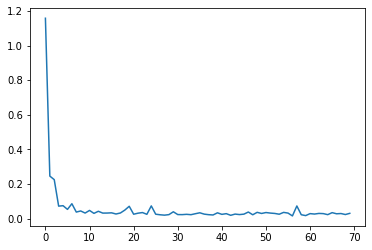

In [13]:
plt.plot(np.array(all_eval_losses))

In [14]:
#creation du dataset de graph pour le submit
class MySubmitDataset(Dataset):
  def __init__(self):
    super().__init__()
  def read(self):
    graphs=[]
    for id in range(6774,8463): #on prend les indices correspondant à atom_test
      path = '/content/drive/MyDrive/nouveau/atoms/test/id_{}.xyz'.format((id))
      mol=io.read(path)
      analyzed_mol=Analysis(mol)
      a=analyzed_mol.adjacency_matrix #matrice d'ajacence de la molécule au format DOK
      a=a[0].todense() #décompression
      a=a.astype(np.float32)
      na=pd.DataFrame(mol.get_atomic_numbers())
      pos=pd.DataFrame(mol.get_positions())
      x=np.array(pd.concat([na,pos],axis=1))
      x=x.astype(np.float32)
      e=get_bonds_length(analyzed_mol)
      y=0
      graph=sp.data.graph.Graph(x=x,a=a,e=e,y=y)
      graphs.append(graph)
    return graphs

In [15]:
submit_dataset=MySubmitDataset()
submit_dataset.apply(GCNFilter())
print(submit_dataset.n_graphs)
submit_loader=BatchLoader(submit_dataset,batch_size=submit_dataset.n_graphs,mask=True,shuffle=False)

1689


In [16]:
#ptit trick pour compute les valeurs prédites
for batch in submit_loader:
  inputs,_=batch
  pred=best_model.predict(inputs)
  break

predictions=pd.DataFrame([])
predictions['id']=range(6774,8463)
predictions['predicted']=pred
predictions=predictions.set_index(['id'])
predictions.head()
filepath=Path('/content/drive/MyDrive/predictions.csv')
predictions.to_csv(filepath)